In [52]:
import os
import tensorflow as tf
import keras
from keras.utils.vis_utils import plot_model
from crop_img import get_bands_arr
from PIL import Image
import numpy as np
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from keras.utils.np_utils import to_categorical

In [53]:
classify_model_path = './train_data/cnn_weights/CNN_classification_0.828.h5'
unet_model_path = './resnet34_B8A_B11_B12_82.h5'
classify_model = tf.keras.models.load_model(classify_model_path)
unet_model = tf.keras.models.load_model(unet_model_path, custom_objects={'binary_crossentropy_plus_jaccard_loss':bce_jaccard_loss, 'iou_score':iou_score})

In [83]:
# Input tile
tile = 'L1C_T51VWJ_A031818_20210726T030546'
tile_no = 15

In [84]:
# Bands used for training
classify_bands = ['B3', 'B4', 'B8', 'B8A', 'B11', 'B12']
unet_bands = ['B8A', 'B11', 'B12']

In [85]:
# Load data as numpy array
classify_arr = get_bands_arr(tile, tile_no, classify_bands, 9, (2700,2700))
unet_arr = get_bands_arr(tile, tile_no, unet_bands, 9, (256*9, 256*9))

In [86]:
# classification model predictions
pred = classify_model.predict(classify_arr)
predictions = pred.argmax(axis=1)
predictions = predictions.reshape(9,9)

3/3 [==============================] - 0s 55ms/step


In [87]:
out_image = Image.new('RGB', (2700, 2700), color='black')

In [88]:
# store patches predicted in mixed class by classification model
# in unet_input and color rest in out_image
unet_input = []
for i in range(9):
    for j in range(9):
        box = (i*300, j*300, i*300+300, j*300+300)
        if predictions[i,j] == 1:
            out_image.paste('#ff0000', box)
        elif predictions[i,j] == 2:
            out_image.paste('#00ff00', box)
        elif predictions[i,j] == 3:
            out_image.paste('#ffffff', box)
        else:
            unet_input.append((i*9+j, box))

In [89]:
# generate numpy array for unet predictions
unet_input_arr = np.zeros((len(unet_input), 256,256,3))
for i in range(len(unet_input)):
    unet_input_arr[i] = unet_arr[unet_input[i][0]]
unet_input_arr.shape

(38, 256, 256, 3)

In [90]:
unet_prediction = unet_model.predict(unet_input_arr)
unet_pred = to_categorical((unet_prediction.argmax(
    axis=3)), num_classes=4).astype('uint8') * 255
unet_pred = unet_prediction.argmax(axis=3)

2/2 [==============================] - 4s 735ms/step


In [91]:
nparr = unet_pred[i]
nparr.shape

(256, 256)

In [92]:
# paste unet predictions in output image
for i in range(len(unet_input)):
    nparr = unet_pred[i]
    
    other = nparr == 0
    burned = nparr == 1
    vegetation = nparr == 2
    unknown = nparr == 3

    pred_arr = np.zeros(nparr.shape + (3,), dtype='uint8')
    pred_arr[vegetation] = [0, 255, 0]
    pred_arr[burned] = [255, 0, 0]
    pred_arr[unknown] = [255, 255, 255]

    temp_img = Image.fromarray(pred_arr)
    # x = unet_input[i][0]
    # box = (x // 9 * 300, x % 9 * 300)
    box = unet_input[i][1]
    out_image.paste(temp_img.resize((300,300)), box)

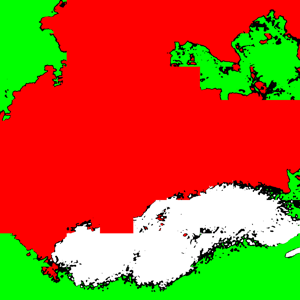

In [93]:
# Output Image
out_image.resize((300,300))

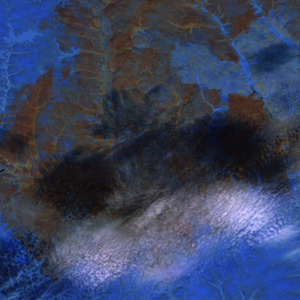

In [95]:
# Atmospheric penetration image
path = f'./cropped/atm_penetration/{tile}_B12_B11_B8A_{tile_no}.jpg'
Image.open(path).resize((300,300))

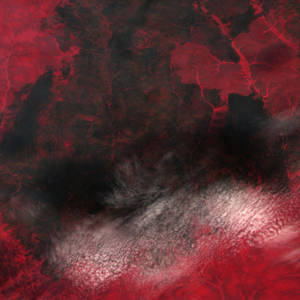

In [96]:
# Color infrared image
path = f'./cropped/infrared/{tile}_B8_B4_B3_{tile_no}.jpg'
Image.open(path).resize((300,300))